## v1_custom 파일을 기반 쉽고 빠르게 수정할 수 있는 쥬피터 노트북  

## import

In [65]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *

import random

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import multiprocessing

import timm

from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [50]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [51]:
### cofiguration
seed = 42
check_point_name = 'resnet34'

data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/custom_train.csv'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

train_b_size = 64
valid_b_size = 1000
test_b_size = 1000
epochs = 25

lr = 1e-4

model_name = 'resnet34'
num_labels = 18

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

In [52]:



train_df = pd.read_csv(train_csv_path)
imgs_path = train_df['path'] 
labels = train_df['class'] # input your label feature
stratify_col = train_df['class']

train_paths, valid_paths, train_labels, valid_labels = train_test_split(imgs_path, labels,
                                                                        train_size=0.7,
                                                                        shuffle=True,
                                                                        random_state=seed,
                                                                        stratify=stratify_col)

## datasets class

In [53]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, img_paths : pd.Series, labels : pd.Series, label_col='class', transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        if label_col == 'gender':
            self.labels = pd.get_dummies(labels).to_numpy()
        elif label_col == 'mask_state':
            self.labels = pd.get_dummies(labels).to_numpy()
        else: # age, classes
            self.labels = labels.to_numpy()
        ## if (False), assert occur
        assert self.transforms is not None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

## augmentations

In [54]:
train_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.HorizontalFlip(p=0.5),
                              A.RandomBrightnessContrast(p=0.5),
                              A.GaussianBlur(p=0.5),
                              A.GridDistortion(p=0.5),
                              A.Rotate(limit=30, p=0.5),
                              A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                              std=(0.23318603,0.24300033,0.24567522)),
                              ToTensorV2()])

valid_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                              std=(0.23318603,0.24300033,0.24567522)),
                              ToTensorV2()])

## make dataset and dataloader

In [55]:
train_dset = CustomTrainDataset(train_paths, train_labels, 'class', train_transforms)
va_dset = CustomTrainDataset(valid_paths, valid_labels, 'class', valid_transforms)

In [56]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=True,
    )

val_loader = DataLoader(
        va_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

## visualization transform

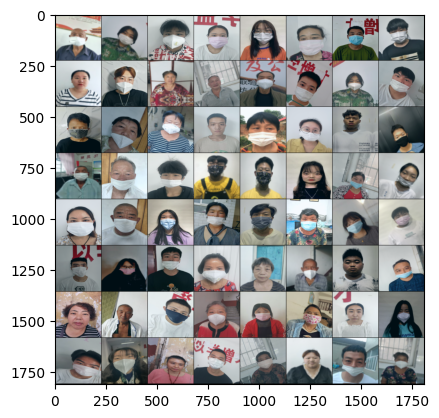

In [57]:
## for check transform
imgs, labels = next(iter(train_loader))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model, Optimzer, Scheduler, Loss function, Metric

In [64]:
model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_labels)
model.to(device)
model = torch.nn.DataParallel(model)

In [85]:
model(torch.Tensor(1,3,336,336))

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
criterion = nn.CrossEntropyLoss()
# if you param freeze, not update during training
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr) 

## Train

In [ ]:
for epoch in range(epochs)